In [2]:
from sklearn.grid_search import GridSearchCV
from time import time
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics,  cross_validation

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

/Users/Xiaonan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Xiaonan/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_csv('titanic_train.csv')

In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [7]:
target = data.Survived
X = data[['Pclass','Sex','Age','Fare']]

In [8]:
X = X.fillna(-1)

In [9]:
X.isnull().sum()

Pclass    0
Sex       0
Age       0
Fare      0
dtype: int64

In [10]:
Pclass_dummy = pd.get_dummies(X.Pclass,prefix = 'Pclass')
Sex_dummy = pd.get_dummies(data['Sex'], prefix='Sex')

In [11]:
X = pd.concat([X,Pclass_dummy,Sex_dummy],axis =1)
X = X.drop(['Pclass','Sex'],axis = 1)

In [14]:
X = X.drop(['Sex_female','Pclass_3'], axis = 1)
X.head(2)

,Age,Fare,Pclass_1,Pclass_2,Sex_male
0,22.0,7.2500,0,0,1
1,38.0,71.2833,1,0,0


In [22]:
target.head(2)

0    0
1    1
Name: Survived, dtype: int64

In [50]:
from sklearn.cross_validation import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X.values, target, test_size=0.2, random_state=0)


# Model evaluation

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
from sklearn.preprocessing import StandardScaler


In [34]:
# build evaluation pipeline

imputer = Imputer(missing_values= -1, strategy='mean')

scaler = StandardScaler(with_mean=True, with_std=True)

rf = RandomForestClassifier(n_estimators= 100, random_state= 1234, criterion='gini')
logreg = LogisticRegression(C = 1, random_state= 1234)


In [52]:
classifier = rf # change this one to use preferred model

pipeline = Pipeline([
    ('imp',imputer),
    ('scaler',scaler),
    ('clf', classifier),
          ])

params = {
    'imp__strategy': ['mean', 'median'],
    'clf__n_estimators': [100, 500],
}

In [36]:
def model_evaluation(X_train,y_train, pipeline, param_grid, cv):
    model = GridSearchCV(estimator= pipeline,
                        param_grid = param_grid,
                        cv = cv,
                        scoring = 'roc_auc', 
                         n_jobs=4)
    model.fit(X_train, y_train)
    
    top_score = sorted(model.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:3]
    print("top performance: ", top_score[0] )
    print("top performance: ", top_score[1] )
    print("top performance: ", top_score[2] )
    print ('\n')
    print("best score: %.3f" % model.best_score_)
    print("best parameters: ", model.best_params_)
    return model
    




In [53]:
start = time()

model = model_evaluation(X_train, y_train, pipeline, param_grid = params, cv = 5)

print("this takes %.2f seconds" %(time()-start)) 

('top performance: ', mean: 0.85304, std: 0.03279, params: {'imp__strategy': 'median', 'clf__n_estimators': 500})
('top performance: ', mean: 0.85273, std: 0.03832, params: {'imp__strategy': 'mean', 'clf__n_estimators': 500})
('top performance: ', mean: 0.85182, std: 0.03222, params: {'imp__strategy': 'median', 'clf__n_estimators': 100})


best score: 0.853
('best parameters: ', {'imp__strategy': 'median', 'clf__n_estimators': 500})
this takes 18.34 seconds


In [54]:
logreg = LogisticRegression(C = 1, random_state= 1234)
classifier = logreg # change this one to use preferred model

pipeline_2 = Pipeline([
    ('imp',imputer),
    ('scaler',scaler),
    ('clf', classifier),
          ])

params = {
    'imp__strategy': ['mean', 'median'],
    'clf__C': [1, 2, 5],
}

In [55]:
start = time()

model = model_evaluation(X_train, y_train, pipeline_2, param_grid = params, cv = 5)

print("this takes %.2f seconds" %(time()-start)) 

('top performance: ', mean: 0.83655, std: 0.04449, params: {'clf__C': 1, 'imp__strategy': 'mean'})
('top performance: ', mean: 0.83635, std: 0.04387, params: {'clf__C': 5, 'imp__strategy': 'median'})
('top performance: ', mean: 0.83631, std: 0.04366, params: {'clf__C': 1, 'imp__strategy': 'median'})


best score: 0.837
('best parameters: ', {'clf__C': 1, 'imp__strategy': 'mean'})
this takes 0.90 seconds


In [42]:
# scoring = 'accuracy', 'roc_auc'
def model_evaluation_2(X_train,y_train, pipeline, param_grid, cv, scoring):
    model = GridSearchCV(estimator= pipeline,
                        param_grid = param_grid,
                        cv = cv,
                        scoring = scoring, 
                         n_jobs=4)
    model.fit(X_train, y_train)
    
    top_score = sorted(model.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:3]
    print("top performance: ", top_score[0] )
    print("top performance: ", top_score[1] )
    print("top performance: ", top_score[2] )
    print ('\n')
    print("best score: %.3f" % model.best_score_)
    print("best parameters: ", model.best_params_)
    return model

In [ ]:



#This is function to evalute models, scoring is 'log_loss'.
def model_evaluation(X_train, y_train, clf, param_grid, cv):
    model = GridSearchCV(estimator = clf,
                         param_grid = param_grid,
                         scoring = 'log_loss',
                         cv = cv
                         )
    #fit model
    model.fit(X_train,y_train)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters:", model.best_params_)
    return model

In [ ]:
# function to plot feature_importance.
def plot_feature_importance(feature_importances,feature_names):
    ftr_imp_df = pd.DataFrame(sorted(zip(feature_names,feature_importances)
                          , key=lambda x: x[1], reverse = False)
                   )
    y_pos = np.arange(ftr_imp_df.shape[0])

    plt.barh(y_pos, ftr_imp_df[1], align='center', alpha=0.4)
    plt.yticks(y_pos, ftr_imp_df[0])
    plt.xlabel('Feature Importance')

    plt.show()

In [ ]:
from sklearn.pipeline import Pipeline

imputer = Imputer(strategy='median', missing_values=-1)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                        subsample=.8, max_features=.5,
                                        random_state=0)

pipeline = Pipeline([
    ('imp', imputer),
    ('clf', classifier),
])

%%time

params = {
    'imp__strategy': ['mean', 'median'],
    'clf__max_features': [0.5, 1],
    'clf__max_depth': [3, 4, 5],
}
gs = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(X_train, y_train)

In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)
gs.best_score_

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
plot_roc_curve(y_test, gs.predict_proba(X_test))

In [1]:
from sklearn.metrics import confusion_matrix

def plot_confusion(cm, target_names = ['benign','bad'],
                   title='Confusion matrix'):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.tight_layout()
    

In [8]:
## do not normalized it , does not make sense--up to you
# normalized can get TPR and TNR, but other two doesn't make sense
a = np.array([[92,4],
            [2,45]])
a_normed = 1.00* a/a.sum(axis = 1)
a.sum(axis = 1)

array([96, 47])

In [14]:
92.0/96, 4.0/96, 4.0/47, 2.0/96

(0.9583333333333334,
 0.041666666666666664,
 0.0851063829787234,
 0.020833333333333332)

In [7]:
a_normed

array([[ 0.95833333,  0.08510638],
       [ 0.02083333,  0.95744681]])

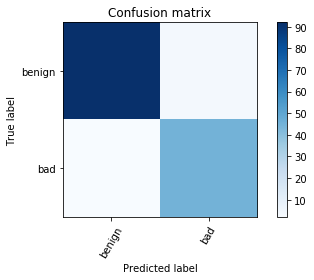

In [15]:
plot_confusion(a)